In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [3]:
data = []

for root, subdirs, files in os.walk('dataset'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in files:
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                data.append((label, points))

In [4]:
print(data[0])

('check', array([[ 77., 181.],
       [ 76., 179.],
       [ 76., 181.],
       [ 76., 183.],
       [ 77., 186.],
       [ 80., 188.],
       [ 81., 190.],
       [ 83., 192.],
       [ 85., 194.],
       [ 86., 197.],
       [ 88., 200.],
       [ 89., 202.],
       [ 91., 204.],
       [ 93., 206.],
       [ 94., 209.],
       [ 95., 211.],
       [ 97., 214.],
       [ 98., 216.],
       [ 99., 219.],
       [101., 221.],
       [101., 224.],
       [102., 226.],
       [103., 228.],
       [103., 230.],
       [104., 233.],
       [105., 235.],
       [106., 233.],
       [105., 230.],
       [105., 228.],
       [105., 226.],
       [105., 223.],
       [105., 221.],
       [105., 217.],
       [105., 215.],
       [105., 211.],
       [106., 208.],
       [107., 202.],
       [108., 200.],
       [110., 195.],
       [111., 190.],
       [112., 184.],
       [115., 178.],
       [115., 176.],
       [117., 174.],
       [120., 169.],
       [123., 164.],
       [125., 162.],
   

In [5]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'check', 'arrow', 'v', 'left_sq_bracket', 'circle', 'rectangle', 'question_mark', 'delete_mark', 'x', 'right_curly_brace', 'star', 'triangle', 'pigtail', 'left_curly_brace', 'caret', 'right_sq_bracket'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
(4224, 50, 2) (1056, 50, 2) (4224, 16) (1056, 16)


In [6]:
# Define the model
model = Sequential()

# add LSTM layer
# input shape is (length of an individual sample, dimensions of the sample)
# in our case: two dimensions, as we have X and Y coordinates
model.add(LSTM(64, input_shape=(NUM_POINTS, 2)))

# add dense layer to do machine learning magic
model.add(Dense(32, activation='relu'))

# here, you can add more layers and maybe a dropout for better performance

# softmax layer for classification
model.add(Dense(len(set(labels)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [7]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
132/132 [==============================] - 13s 47ms/step - loss: 1.4640 - accuracy: 0.5608 - val_loss: 0.3691 - val_accuracy: 0.9081 - lr: 0.0010
Epoch 2/20
132/132 [==============================] - 5s 41ms/step - loss: 0.2431 - accuracy: 0.9302 - val_loss: 0.1585 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 3/20
132/132 [==============================] - 5s 39ms/step - loss: 0.1186 - accuracy: 0.9671 - val_loss: 0.0694 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 4/20
132/132 [==============================] - 5s 40ms/step - loss: 0.0760 - accuracy: 0.9808 - val_loss: 0.0888 - val_accuracy: 0.9754 - lr: 0.0010
Epoch 5/20
132/132 [==============================] - 5s 39ms/step - loss: 0.0686 - accuracy: 0.9825 - val_loss: 0.0386 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 6/20
132/132 [==============================] - 5s 41ms/step - loss: 0.0508 - accuracy: 0.9875 - val_loss: 0.0548 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 7/20
132/132 [==============================] - 5s 41ms/s

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 19,760
Trainable params: 19,760
Non-trainable params: 0
_________________________________________________________________


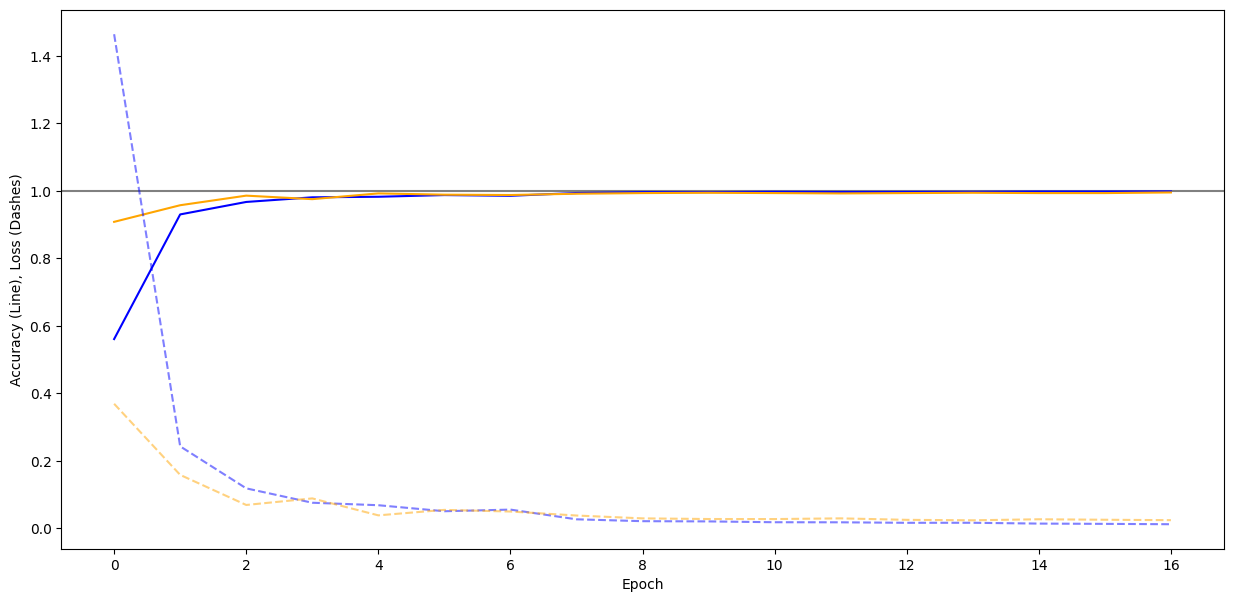

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

33/33 [==============================] - 4s 19ms/step


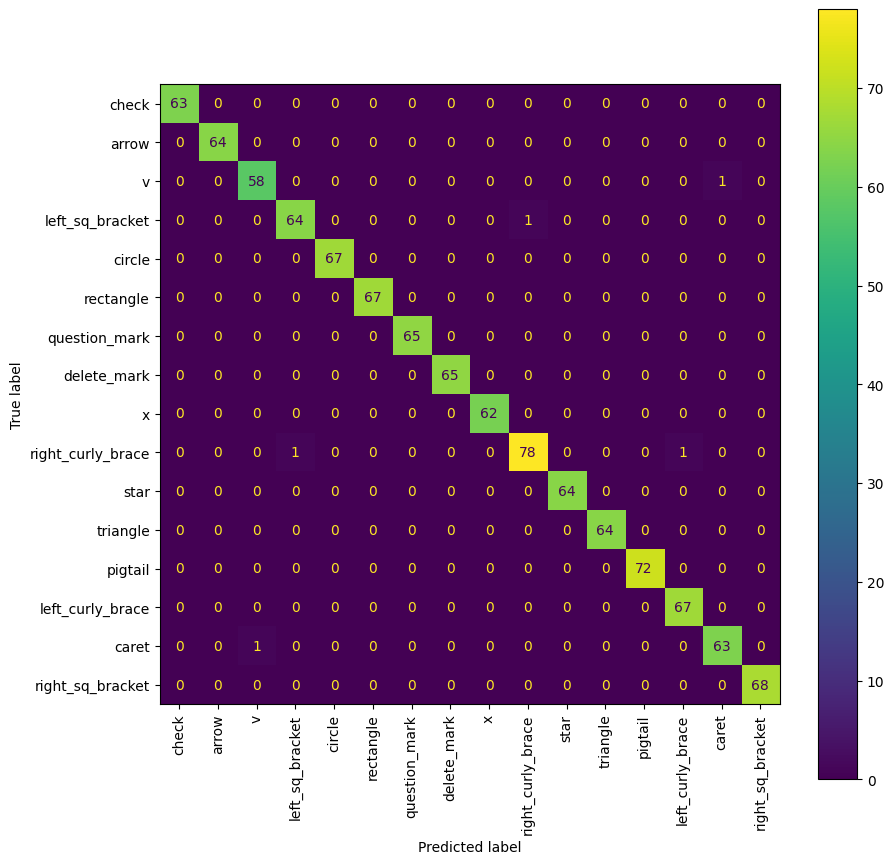

In [10]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 [==============================] - 0s 47ms/step
Label:      pigtail
Prediction: pigtail


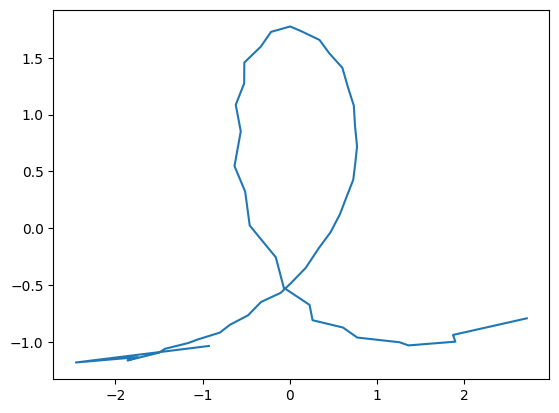

In [15]:
# lets test the model in action

test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)